## Observed heterozygosity / ML Relate

#### Batch 8

The purpose of this notebook is to combine observed heterozygosity and ML Relate to identify potentially contaminated individuals that I should leave out of the analysis. 

ML Relate does this really interesting thing where it only allows you to include 1-2 populations in your genepop file. I found some helpful documentation on that: "Input files can have either one or two POP's (to use the GENEPOP term) in them. If the file has one POP, ML-Relate will estimate allele frequencies in the population from the individuals whose relatedness is being estimated. If the file has two POP's the first POP will be used to estimate allele frequencies and the second POP should contain the individuals to analzye. See the user's manual for more details. "

I'll first run a genepop file with all samples as a single population, to identify samples contaminated between populations. I'll then run genepop files for each population through. 

If ML Relate does not identify all replicates as full siblings, I'll assume that it is not identifying relatedness correctly for that population, and disregard the results. 

<br>
Summary of this notebook: 
1. Plot observed heterozygosity against read depth and missing data
2. Identify individuals with high heterozygosity
3. Run ML Relate on population as a whole, parse results & identify full / half siblings between populations


<br>
<br>
<br>



#### 9/29/2017

In [3]:
cd ../analyses

/mnt/hgfs/Pacific cod/DataAnalysis/PCod-Korea-repo/analyses


In [6]:
!python calc_het.py -h

usage: calc_het.py [-h] [-l LIST] [-i IND] [-f FILE] [-o OUTPUT]
                   [-d DENOMINATOR]

optional arguments:
  -h, --help            show this help message and exit
  -l LIST, --list LIST  Population map, or any white space delimited list of
                        individuals with sample name in first column
  -i IND, --ind IND     name of individual to investigate (mutually exclusive
                        to '-l' and requires '-f') - UNTESTED
  -f FILE, --file FILE  location of file with genotypes (assumes genepop
                        format)
  -o OUTPUT, --output OUTPUT
                        name of output file
  -d DENOMINATOR, --denominator DENOMINATOR
                        use 2 if counting a FASTA file or 4 if counting a
                        FASTQ file


In [7]:
!python calc_het.py \
-l ../scripts/PopMap_L1-5_mdFilter_b8.txt \
-f ../stacks_b8_wgenome/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE.gen \
-o Het_Depth_MissingData_b8.txt \
-d 4

In [10]:
!python calc_missing_genotypes.py -h

usage: calc_missing_genotypes.py [-h] [-l LIST] [-i IND] [-f FILE] [-o OUTPUT]
                                 [-d DENOMINATOR]

optional arguments:
  -h, --help            show this help message and exit
  -l LIST, --list LIST  Population map, or any white space delimited list of
                        individuals with sample name in first column
  -i IND, --ind IND     name of individual to investigate (mutually exclusive
                        to '-l' and requires '-f') - UNTESTED
  -f FILE, --file FILE  location of file with genotypes (assumes genepop
                        format)
  -o OUTPUT, --output OUTPUT
                        name of output file
  -d DENOMINATOR, --denominator DENOMINATOR
                        use 2 if counting a FASTA file or 4 if counting a
                        FASTQ file


In [13]:
!python calc_missing_genotypes.py \
-l ../scripts/PopMap_L1-5_mdFilter_b8.txt \
-f ../stacks_b8_wgenome/batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE.gen \
-o MissingData_b8.txt \
-d 4

*I already had read depths, so I manually combined the above into a single file. *

In [18]:
## open file and save each number into appropriate list ##
infile = open("Het_Depth_MissingData_b8.txt", "r")
het_dict = {}
het = []
reads = []
missing = []
infile.readline()
for line in infile:
    linelist = line.strip().split()
    het_dict[linelist[0]] = float(linelist[1])
    het.append(float(linelist[1]))
    reads.append(float(linelist[2]))
    missing.append(float(linelist[3]))
infile.close()


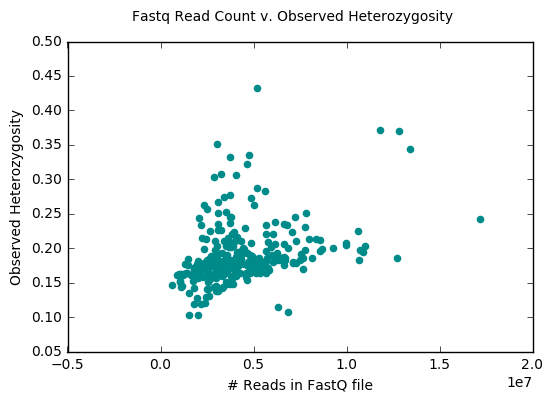

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
plt.scatter(reads, het, color = "darkcyan")
plt.suptitle("Fastq Read Count v. Observed Heterozygosity")
plt.xlabel("# Reads in FastQ file")
plt.ylabel("Observed Heterozygosity")
plt.show()

In [20]:
plt.close()

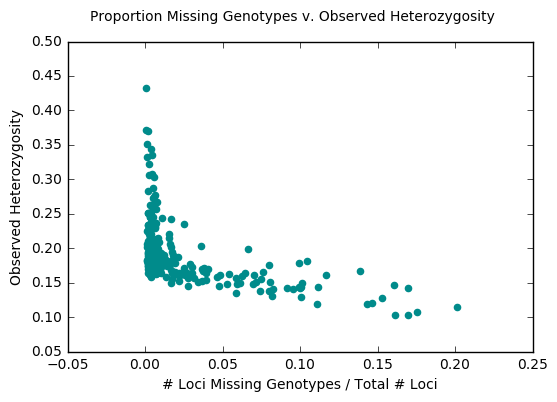

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
plt.scatter(missing, het, color = "darkcyan")
plt.suptitle("Proportion Missing Genotypes v. Observed Heterozygosity")
plt.xlabel("# Loci Missing Genotypes / Total # Loci")
plt.ylabel("Observed Heterozygosity")
plt.show()

In [22]:
plt.close()

In [25]:
outfile = open("batch_8_HighLowHet.txt", "w")
outfile.write("# Individuals with very high (possible contam) or very low (possible missing data) heterozygosity\n")

low_het_individs = {}
high_het_individs = {}

for sample in het_dict.keys():
    if float(het_dict[sample]) > 0.25:
        high_het_individs[sample] = het_dict[sample]
    elif float(het_dict[sample]) < 0.13:
        low_het_individs[sample] = het_dict[sample]

outfile.write("\n# High Heterozygosity\n")
for i in high_het_individs.keys():
    outfile.write(i + "\t" + str(high_het_individs[i]) + "\n")
    
outfile.write("\n# Low Heterozygosity\n")
for i in low_het_individs.keys():
    outfile.write(i + "\t" + str(low_het_individs[i]) + "\n")
outfile.close()

<br>
<br>
### ML Relate - One Pop

#### FILE: batch_8_filteredMAF_filteredIndivids30_filteredLoci_filteredHWE_onepop.txt

Calculate relatedness using `Relationship` >> `Relatedness` >> `List Output`

In [ ]:
infile = open("batch_8_MLrelate_all_list.txt", "r")
outfile = open("batch_8_MLrelate_all_relatedIndivids.txt", "w")

outfile.write("relatedness\tsample1\tsample2\n")

for line in infile:
    if line.startswith("Ind1"):
        break

r_count = 0
u_count = 0

halfsibs = ""
hs_count = 0
fullsibs = ""
fs_count = 0
for line in infile:
    linelist = line.strip().split()
    if len(linelist) > 2:
        relate = linelist[2]
        if relate == "HS":
            halfsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            hs_count += 1
        elif relate == "FS":
            fullsibs += relate + "\t" + linelist[0] + "\t" + linelist[1] + "\n"
            r_count += 1
            fs_count += 1
        else:
            u_count += 1
infile.close()

outfile.write(fullsibs)
outfile.write(halfsibs)
outfile.close()

print r_count, " detected related pairs: ", hs_count, " half sib pairs & ", fs_count, " full sib pairs."
print u_count, " unrelated pairs"

By looking at the pairs in excel, I found that:

+++ of +++ full sib pairs were replicates.

+++ of +++ half sib pairs were replicates.

+++ replicates went undetected.